In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from datetime import timedelta, datetime
import time
from threading import Thread
import jwt
import requests

In [3]:

class MDApiConnector():    
    algo = "HS256"

    def __init__(self, client_id, app_id, key):
        self.client_id = client_id
        self.app_id = app_id
        self.key = key
        self.API_URL = "https://api-live.exante.eu/md/2.0"

    def __request(self, endpoint, params=None):
        result = requests.get(self.API_URL + endpoint,
                              auth = (self.app_id, self.key),
                              timeout=15,
                              params=params)
        result.raise_for_status()
        return result.json()

    def get_accounts(self):
        res = self.__request("/accounts")
        return res
    
    def get_futures(self):
        res = self.__request("/types/FUTURE")
        return res
    
    def get_f(self):
        res = self.__request("/orders/active")
        return res

    def get_ohlc(self, symbolId, timeframe=86400, size=5000):
        # 86400 (sec) - day duration
        ohlc = self.__request("/ohlc/{0}/{1}".format(symbolId, timeframe), {"size": size})
        return ohlc
    
    def get_ohlc_df(self, ticker, timeframe=60, size=5000):
        try:
            ohlc = self.get_ohlc(ticker, timeframe, size)
            df = pd.DataFrame(ohlc)
            df.set_index(pd.to_datetime(df['timestamp']*1e6), inplace=True)
            del df['timestamp']
            df.sort_index(inplace=True)
            return df[['close']]
        except Exception as e:
            print(e)
            return None
    
    def custom_request(self, request_str):
        res = self.__request(request_str)
        return res
        
        


In [4]:
md = MDApiConnector(
    client_id = '896300f4-d067-40e3-ae17-5959ca4ce73d',
    app_id = 'bb291c2d-d9cd-4e8e-ba26-a24736b8edde',
    key = 'i2TlwVyJnUhg5DVAEmjG'
)


In [6]:
name_dict = {
    'BR':['BR.FORTS.K2021', 'B.ICE.M2021'],
    'GC':['GOLD.FORTS.H2021', 'GC.COMEX.J2021'],
    'NG':['NG.FORTS.H2021', 'NG.NYMEX.J2021']
}

dfs = {}
df = pd.DataFrame()
for n_pair in name_dict:
    for n in name_dict[n_pair]:
        
        df_i = md.get_ohlc_df(ticker=n, timeframe=60, size=5000)
        df_i.columns = [n]
        df_i[n] = df_i[n].apply(float)

        df = df.join(df_i, how='outer')
        df.dropna(inplace=True)
        
        dfs[n_pair] = df.copy()



In [140]:
pos_dict = {
    "NG": {"price":0.015, "dir":"buy"},
    "GC":{"price":0.2, "dir":"sell"}
}

In [7]:
(dfs[name][name_list[0]] - dfs[name][name_list[1]]).iloc[-1]

NameError: name 'name' is not defined

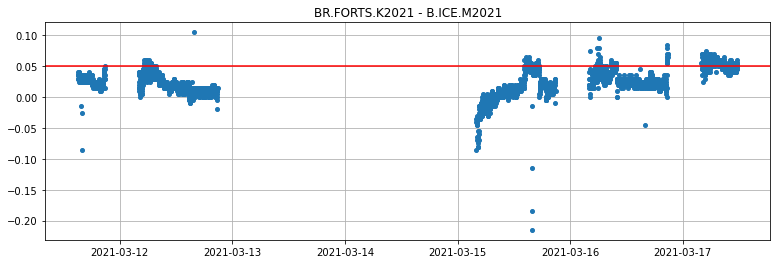

0.04999999999999716


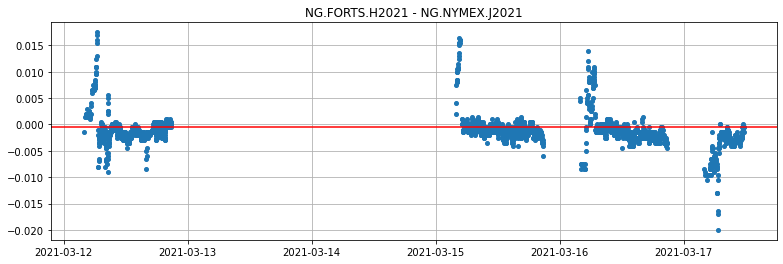

-0.000500000000000167


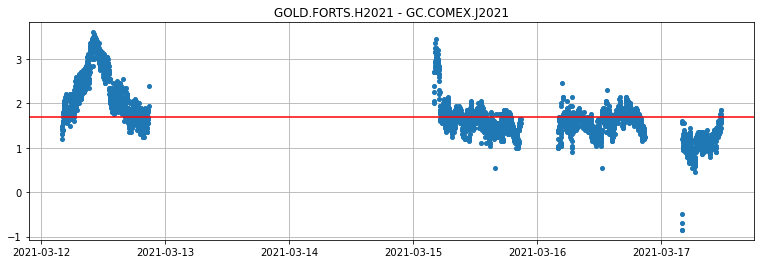

1.7000000000000455


In [8]:
for name in ['BR','NG','GC']:

    name_list = list(name_dict[name])

    plt.figure(figsize=(13,4))
    plt.plot((dfs[name][name_list[0]] - dfs[name][name_list[1]]), linestyle='none', marker='o', markersize=4)
    plt.axhline((dfs[name][name_list[0]] - dfs[name][name_list[1]]).iloc[-1], color='red')
    plt.grid()
    plt.title('{0} - {1}'.format(name_list[0], name_list[1]))
    plt.show()

    print((dfs[name][name_list[0]] - dfs[name][name_list[1]]).iloc[-1])

In [44]:
(dfs['GC'][name_list[0]] - dfs['GC'][name_list[1]]).mean()

2.4831232970027224

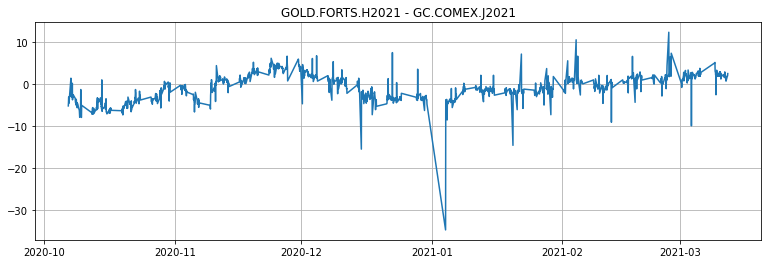

In [19]:
plt.figure(figsize=(13,4))
plt.plot((dfs['GC'][name_list[0]] - dfs['GC'][name_list[1]]).iloc[-1500:])
plt.grid()
plt.title('{0} - {1}'.format(name_list[0], name_list[1]))
plt.show()